# Word Embedding 1

### Metadata

```
MacKenzye Leroy (zuf9mc@virginia.edu)
DS 5001
May 2, 2022
 
Purpose:  XXX
```

# Set Up

In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
from scipy.linalg import norm

In [2]:
import plotly.express as px
import seaborn as sns; sns.set()
import os

In [3]:
norm_docs = True # L2 norming
center_by_mean = True 
center_by_variance = False # Not supposed to ... Exaggerates significance of rare words
n_terms = 1000 # Number of significant words; feature space
k = 6 # Number of components

In [4]:
os.chdir('/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject')
home_dir = os.getcwd()
home_dir

'/Users/mackenzyeleroy/Documents/MSDS/DS5001/FinalProject'

In [5]:
data_home = f"{home_dir}/Data"

parser_lib = f"{home_dir}/lib"
source_files = f'{data_home}/output'
data_prefix = 'wells-verne'

In [6]:
OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [7]:
w2v_params = dict(
    min_count = 10,
    workers = 4,
    # vector_size = 246,
    vector_size = 100,
    window = 2    
)

In [8]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random',
    n_iter = 1000,
    random_state = 23    
)

# Get Data

In [9]:
TOKENS = pd.read_csv(f"{source_files}/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [10]:
TOKENS.head()

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                
35      1       0        0        0          ('Introduction', 'NN')   NN   
                1        0        0                   ('The', 'DT')   DT   
                                  1                 ('Time', 'NNP')  NNP   
                                  2            ('Traveller', 'NNP')  NNP   
                                  3                 ('(for', 'NNP')  NNP   

                                                token_str      term_str  
book_id chap_id para_num sent_num token_num                              
35      1       0        0        0          Introduction  introduction  
                1        0        0                   The           the  
                                  1                  Time          time  
                                  2             Traveller     traveller  
                                  3                  (for           for

# Extract VOCAB

Use this to filter significant terms and to store w2v features and tSNE coordinates.

In [11]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'

In [12]:
VOCAB['pos_max'] = TOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)

In [13]:
VOCAB['pos_group'] = VOCAB.pos_max.str.slice(0,2)

# Add Chapter Significance

In [14]:
CHAPS = TOKENS.groupby(OHCO[:2]+['term_str']).term_str.count()\
    .unstack(fill_value=0).astype('bool').astype('int')

In [15]:
CHAPS.head()

term_str         0  000436  016  05  092  0h  1  10  100  1000  ...  â  \
book_id chap_id                                                 ...      
35      1        0       0    0   0    0   0  0   0    0     0  ...  0   
        2        0       0    0   0    0   0  0   0    0     0  ...  0   
        3        0       0    0   0    0   0  0   0    0     0  ...  0   
        4        0       0    0   0    0   0  0   0    0     0  ...  0   
        5        0       0    0   0    0   0  0   0    0     0  ...  0   

term_str         âtrice  æsthetic  æstheticism  éclat  épicier  ō  œdipus  α  \
book_id chap_id                                                                
35      1             0         0            0      0        0  0       0  0   
        2             0         0            0      0        0  0       0  0   
        3             0         0            0      0        0  0       0  0   
        4             0         0            0      0        0  0       0  0   
        5             0         0            0      0        0  0       0  0   

term_str         β  
book_id chap_id     
35      1        0  
        2        0  
        3        0  
        4        0  
        5        0  

[5 rows x 40079 columns]

In [16]:
VOCAB['df'] = CHAPS.sum()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(CHAPS)/VOCAB.df)

In [17]:
VOCAB.sort_values('dfidf', ascending=False)

n pos_max pos_group   df       dfidf
term_str                                           
told         431     VBD        VB  211  304.643433
friends      455      NN        NN  212  304.641132
present      428      JJ        JJ  210  304.638896
master       521      NN        NN  213  304.632026
held         355     VBD        VB  213  304.632026
...          ...     ...       ...  ...         ...
in         29005      IN        IN  574    0.000000
a          41252      DT        DT  574    0.000000
to         44406      TO        TO  574    0.000000
and        58699      CC        CC  574    0.000000
the       126415      DT        DT  574    0.000000

[40079 rows x 5 columns]

# Get List of Token Lists

Because that's what Gensim wants.

In [18]:
SENTS = TOKENS.groupby(OHCO[:-1]).term_str.apply(lambda  x:  x.tolist())

# Learn Word Embeddings

In [19]:
SENTS.head().tolist()

[['introduction'],
 ['the',
  'time',
  'traveller',
  'for',
  'so',
  'it',
  'will',
  'be',
  'convenient',
  'to',
  'speak',
  'of',
  'him',
  'was',
  'expounding',
  'a',
  'recondite',
  'matter',
  'to',
  'us'],
 ['his',
  'pale',
  'grey',
  'eyes',
  'shone',
  'and',
  'twinkled',
  'and',
  'his',
  'usually',
  'pale',
  'face',
  'was',
  'flushed',
  'and',
  'animated'],
 ['the',
  'fire',
  'burnt',
  'brightly',
  'and',
  'the',
  'soft',
  'radiance',
  'of',
  'the',
  'incandescent',
  'lights',
  'in',
  'the',
  'lilies',
  'of',
  'silver',
  'caught',
  'the',
  'bubbles',
  'that',
  'flashed',
  'and',
  'passed',
  'in',
  'our',
  'glasses'],
 ['our',
  'chairs',
  'being',
  'his',
  'patents',
  'embraced',
  'and',
  'caressed',
  'us',
  'rather',
  'than',
  'submitted',
  'to',
  'be',
  'sat',
  'upon',
  'and',
  'there',
  'was',
  'that',
  'luxurious',
  'after',
  'dinner',
  'atmosphere',
  'when',
  'thought',
  'runs',
  'gracefully',
  

In [20]:
model = word2vec.Word2Vec(SENTS.values, **w2v_params)

In [21]:
W2V = pd.DataFrame(model.wv.get_normed_vectors(), index=model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [22]:
W2V.head()

0         1         2         3         4         5   \
term_str                                                               
1        -0.239735  0.032816  0.241029 -0.018022  0.091898 -0.138015   
10       -0.252813  0.070423  0.148423 -0.030387  0.154483 -0.191056   
100      -0.268399  0.077797  0.059224  0.040023  0.091169 -0.158532   
1000     -0.316432  0.086379  0.042941  0.111568  0.127562 -0.188050   
10th     -0.133635  0.221203 -0.035599  0.133871  0.019659 -0.029385   

                6         7         8         9   ...        90        91  \
term_str                                          ...                       
1         0.005742  0.105048 -0.040632 -0.081212  ...  0.017644  0.056834   
10       -0.059352  0.107998 -0.034355 -0.084480  ...  0.092748  0.058932   
100      -0.098351  0.081023  0.050433 -0.020936  ...  0.016253  0.051677   
1000     -0.040692  0.164481 -0.018990 -0.034858  ...  0.082380  0.039679   
10th      0.107622  0.201926 -0.074493 -0.078080  ...  0.044878  0.026342   

                92        93        94        95        96        97  \
term_str                                                               
1         0.005670 -0.050961  0.143088  0.207718  0.051561 -0.089033   
10        0.041477 -0.065169  0.058970  0.192815  0.002904 -0.081596   
100       0.064885 -0.097220  0.125073  0.175130  0.002774 -0.022700   
1000      0.062066 -0.128041  0.044711  0.111161 -0.001198 -0.070130   
10th     -0.014696  0.075150  0.146315  0.100040  0.035715 -0.011545   

                98        99  
term_str                      
1         0.048140  0.010279  
10        0.046756  0.030432  
100      -0.004660  0.073849  
1000      0.070759  0.095436  
10th     -0.046238  0.023156  

[5 rows x 100 columns]

# Visualize with tSNE

In [23]:
tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)

In [24]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index)\
    .join(VOCAB, how='left')[['x','y','n','dfidf','pos_group']]

In [25]:
COORDS

x          y     n       dfidf pos_group
term_str                                                   
1          33.258251  45.470230  92.0  151.300684        CD
10         33.902992  44.999588  36.0  100.224380        CD
100        36.278099  42.478848  18.0   82.638511        CD
1000       37.015194  42.961624  16.0   62.760228        CD
10th       52.276768  31.601688  30.0  119.070524        CD
...              ...        ...   ...         ...       ...
zoofs     -52.061569   3.663757  15.0   58.429788        NN
zoophytes  25.081570  10.174276  15.0   66.959333        NN
zzzz      -25.579063  15.769105  21.0   44.502864        NN
β         -45.825073   2.195914  13.0   28.659628        NN
NaN       -58.201073  19.770586   NaN         NaN       NaN

[10209 rows x 5 columns]

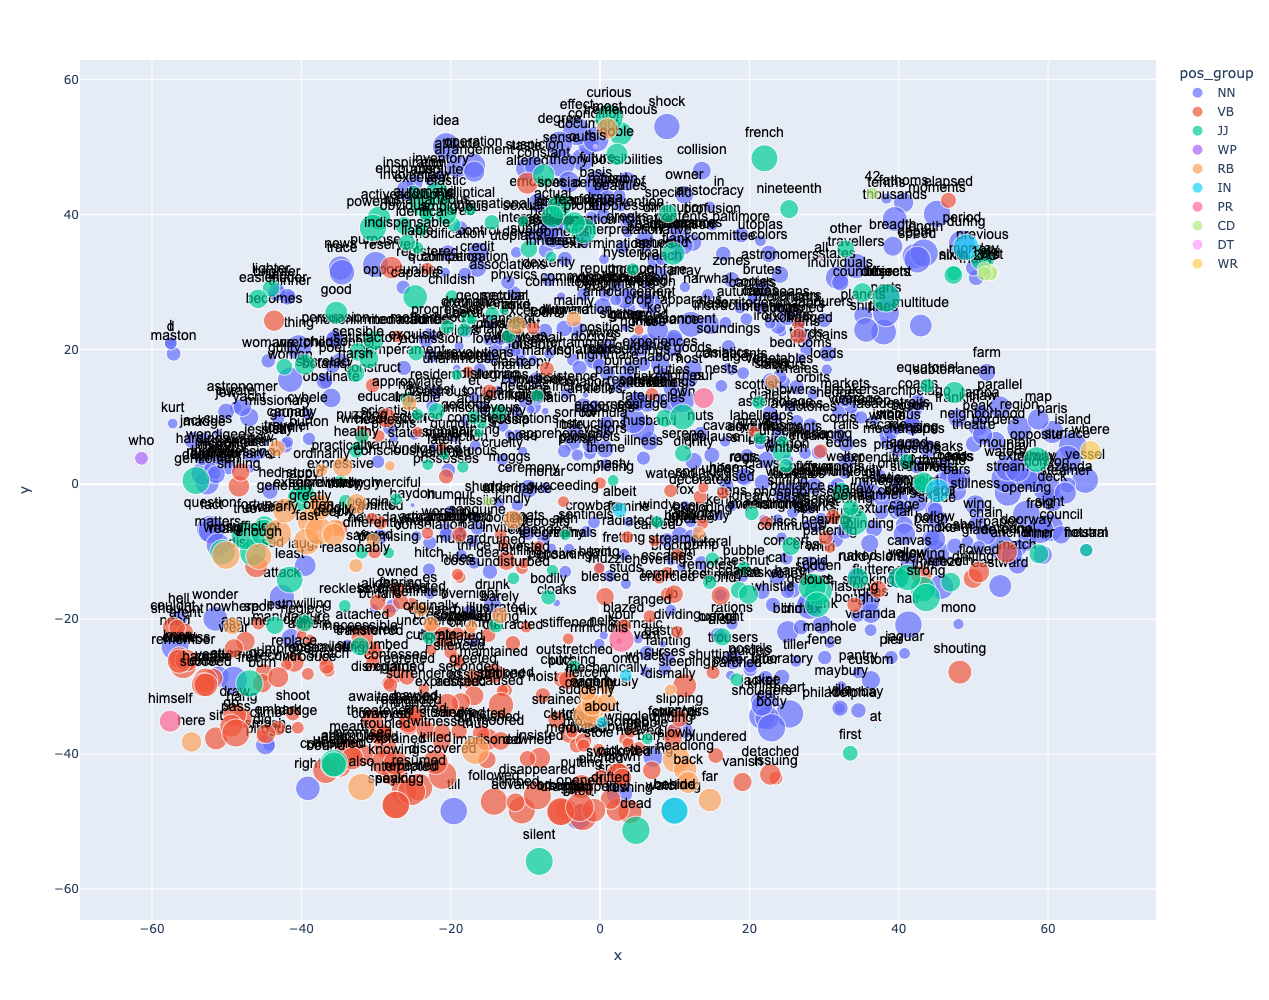

In [26]:
px.scatter(COORDS.reset_index().sample(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

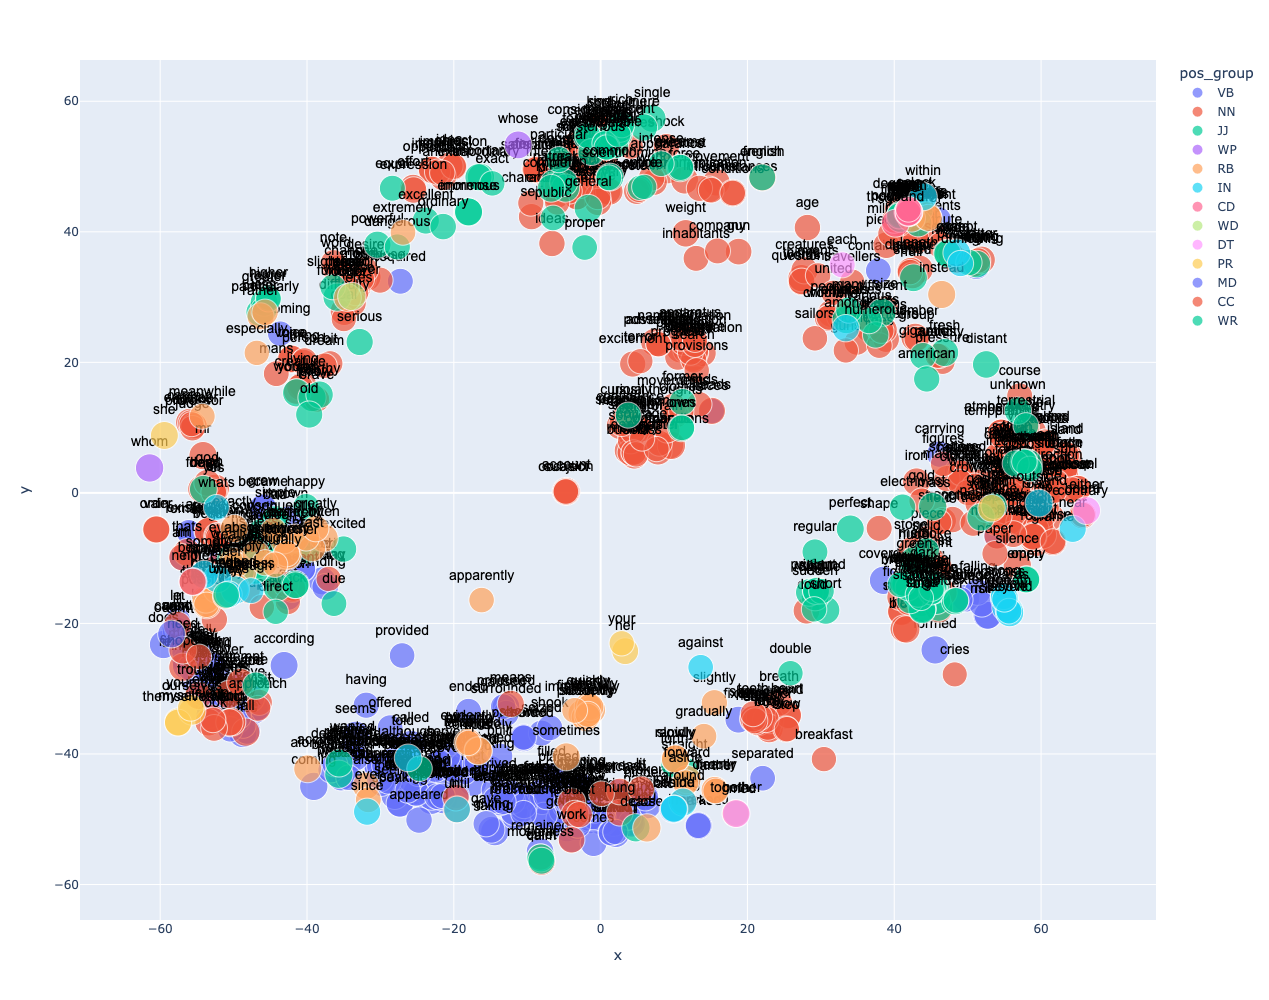

In [27]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(1000), 
           'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1200).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Semantic Algebra

## Analogies

$A : B :: C : D? \rightarrow B - A + C = D$


In [28]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [29]:
complete_analogy('man', 'boy', 'woman', 3)

term       sim
0   dear  0.764067
1   boys  0.741017
2  child  0.700129

In [30]:
complete_analogy('girl', 'daughter', 'boy', 3)

term       sim
0      father  0.838572
1      cousin  0.824116
2  excellency  0.819064

In [31]:
complete_analogy('girl', 'sister', 'boy', 3)

term       sim
0  excellency  0.845061
1      cousin  0.830814
2    daughter  0.826015

In [32]:
complete_analogy('man', 'gentleman', 'woman', 5)

term       sim
0  mulatto  0.794425
1   wretch  0.771705
2     poet  0.770309
3    widow  0.767120
4   beggar  0.763929

In [33]:
complete_analogy('woman', 'lady', 'man', 5)

term       sim
0          bert  0.666436
1        ostrog  0.651785
2          kurt  0.650450
3          hans  0.650179
4  passepartout  0.644318

In [34]:
complete_analogy('day', 'sun', 'night', 5)

term       sim
0     wind  0.750900
1      sky  0.725498
2    waves  0.712019
3     tide  0.699892
4  horizon  0.690224

## Similarites

In [35]:
get_most_similar('joy')

term       sim
0     amazement  0.909220
1          rage  0.881805
2      laughter  0.864760
3       disgust  0.851000
4      approval  0.848951
5  astonishment  0.848407
6         tones  0.842945
7    perplexity  0.839996
8     trembling  0.838001
9        hoarse  0.835419

In [36]:
get_most_similar('man')

term       sim
0        woman  0.741613
1          ape  0.734049
2    invisible  0.732313
3     creature  0.713657
4  unfortunate  0.709528
5          dog  0.707465
6     thickset  0.686925
7      medical  0.674869
8        dying  0.665641
9        young  0.663851

In [37]:
get_most_similar(positive=['man'], negative=['woman'])

term       sim
0         him  0.412155
1          us  0.355226
2          he  0.342519
3     balloon  0.334170
4  themselves  0.333508
5        them  0.333297
6      follow  0.332579
7        keep  0.313471
8        back  0.310978
9     himself  0.310268

In [38]:
get_most_similar(positive='woman')

term       sim
0        young  0.829200
1         girl  0.804920
2     creature  0.797421
3        faced  0.785306
4       haired  0.763421
5        widow  0.753089
6        child  0.745032
7      officer  0.741996
8          man  0.741613
9  unfortunate  0.740433

In [39]:
get_most_similar(positive=['woman'], negative=['man'])

term       sim
0        fine  0.450416
1    handsome  0.402247
2         pet  0.396741
3     slender  0.390015
4  containing  0.388811
5     unequal  0.386783
6    distinct  0.386353
7   countless  0.382853
8       named  0.382043
9           3  0.381507

In [40]:
get_most_similar(['man','woman'],['boy','girl'])

term       sim
0     animal  0.466923
1       sort  0.398995
2   enormous  0.394052
3       form  0.383342
4  invisible  0.381087
5     single  0.365781
6     living  0.354631
7         an  0.345820
8        age  0.328607
9       mass  0.328187

# Save

In [42]:
W2V.to_csv(f'{data_home}/output/{data_prefix}-W2V.csv')
VOCAB.to_csv(f'{data_home}/output/{data_prefix}-VOCAB.csv')
SENTS.to_csv(f'{data_home}/output/{data_prefix}-GENSIM_DOCS.csv')

# Experiment: W2V Features as Topics

In [43]:
W2V.describe().T.style.background_gradient(cmap='GnBu')

In [44]:
VSIGS = VOCAB.sort_values('dfidf').tail(1000)

In [45]:
W2Vp = (W2V - W2V.min()) #[0].sort_values().plot()
W2Vp = W2Vp.loc[VSIGS.index]
W2Vp = W2Vp / W2Vp.sum()

In [46]:
# W2Vp[0].sort_values(ascending=False).head(100).plot()

In [47]:
topics = []
for i in W2Vp.columns:
    top_words = ' '.join(W2V.sort_values(i, ascending=False).index[:10])
    print(i, top_words)
    topics.append((i, top_words))

0 master he i barbican we understand passepartout judge torres why
1 into dining expand frontier vein interior fazenda dochart view relapsed
2 x u r y v d personal p q c
3 stage upper berts glance platform leap my mouth foot brissago
4 dead bodies alive heads legs forgetting guns moved sleeping rivals
5 saw hot through along into down dark light slowly toward
6 throughout same history law central itself outer natural needs utopian
7 lower seek higher dig build grow lie pirogue smash sciences
8 average works quarters enormous iron arrangements lines tools some altogether
9 few several number many those two men hitherto couple taken
10 under above below extended can passes towards over wide across
11 instead can cried are saw old iv remained am said
12 that events all law toil thats night heat why true
13 seas europe great passing america counting however any october whether
14 hoped shouldnt began explained presently realised recognised remembered remarked noticed
15 if english as chief

In [48]:
# topics

<AxesSubplot:xlabel='term_str'>

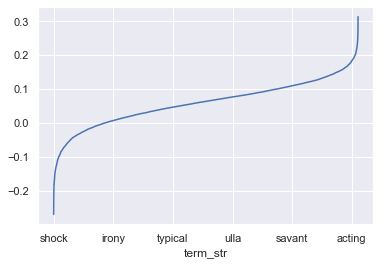

In [49]:
W2V[4].sort_values().plot()

<AxesSubplot:>

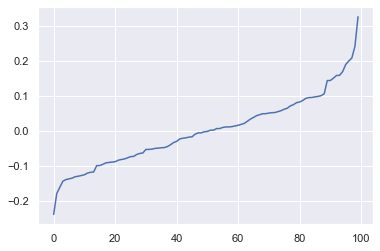

In [50]:
W2V.iloc[0].sort_values().reset_index(drop=True).plot()